# **RUN this cell before you start**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
import string
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import urllib
from tqdm.auto import tqdm

# Topic Classfication with RNN (35 pts)
We will implement RNN for topic classification task.

## Preprocessing
**Do not modify the preprocessing codes.**
You only need to run the cells below.

In [2]:
# Download dataset
TRAIN_URL = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv"
urllib.request.urlretrieve(TRAIN_URL, "train.csv")
i2w = {0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"}

In [3]:
df = pd.read_csv("train.csv", header=None, names=["label", "title", "text"])
df['label'] = df['label']-1
X,y = df['text'].values,df['label'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (96000,)
shape of test data is (24000,)


In [4]:
nltk.download('stopwords')
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    s = re.sub('br','', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:50000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    return np.array(final_list_train, dtype=object), np.array(final_list_test, dtype=object), onehot_dict

print("before tokenization:", x_train[1])
x_train, x_test ,vocab = tokenize(x_train,y_train,x_test,y_test)
print("after tokenization:", x_train[1])

print(f'Length of vocabulary is {len(vocab)}')

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features

#we have very less number of reviews with length > 50.
#So we will consideronly those below it.
print("Before Padding:", x_train[0], len(x_train[0]))
x_train_pad = padding_(x_train,50)
print("After Padding:", x_train_pad[0], len(x_train_pad[0]))
x_test_pad = padding_(x_test,50)

before tokenization:  NEW YORK (Reuters) - U.S. stocks opened higher on  Wednesday, as McDonald's Corp. said third-quarter earnings rose  sharply and quarterly reports from Intel Corp. and Yahoo Inc.  pleased Wall Street, lifting technology shares.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


after tokenization: [2, 20, 4, 3, 163, 813, 205, 10, 7331, 24, 1, 370, 200, 159, 1039, 410, 233, 389, 24, 714, 14, 7644, 313, 251, 3607, 77, 142]
Length of vocabulary is 50000
Before Padding: [118, 1000, 76, 36, 442, 8572, 596, 11, 248, 1074, 1442, 732, 2211, 1150, 3687, 396, 631] 17
After Padding: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  118 1000   76   36  442 8572  596   11  248
 1074 1442  732 2211 1150 3687  396  631] 50


In [5]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.nn.functional.one_hot(torch.from_numpy(y_train)))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.nn.functional.one_hot(torch.from_numpy(y_test)))

# dataloaders
batch_size = 128

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

dataiter = iter(train_loader)
sample_x, sample_y = next(iter(train_loader))

print("Total number of training data :", len(train_loader.dataset))
print("Total number of validation data :", len(valid_loader.dataset))
print('Sample batch size: ', sample_x.size()) # batch_size, seq_length
print('Sample x: \n', sample_x[0])
print('Sample y: \n', sample_y[0])

Total number of training data : 96000
Total number of validation data : 24000
Sample batch size:  torch.Size([128, 50])
Sample x: 
 tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 10046,  1977,   928,   285,
          787,   231,   257,  1091,  1956,  1325,   103,   181,  1977,   928,
           11,  3969, 10372,  1828,  2605,   352,   665,  1383,  1034,   703,
          231,  4546,   973,    83,   901,  7625, 22077,  1495,   683,   143])
Sample y: 
 tensor([1, 0, 0, 0])


## Implementing an RNN model with PyTorch (15 pts)
In this question, we are going to implement a SimpleRNN class to classify AG news dataset. Complete the code following the instruction in the jupyter notebook file.


**(a)** Implement the `__init__()` function of **SimpleRNN** class. **(5 pts)**


**(b)** Implement the `forward()` function of SimpleRNN** class. **(10 pts)**

In [6]:
# Define RNN Model
class SimpleRNN(nn.Module):
    def __init__(self, num_layers, output_dim, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5):
        super(SimpleRNN,self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.num_layers = num_layers
        self.vocab_size = vocab_size

        ### YOUR CODE HERE (~5 lines)

        # 1. Initialize the embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        # 2. Initialize the RNN layer
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # 3. Initialize the dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # 4. Initialize the linear layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # 5. Initialize the softmax layer
        self.softmax = nn.Softmax(dim=1)

        ### END YOUR CODE

    def forward(self, x):
        """ When sentences come in batch form, return the probability for each class.
        @param x (Tensor) : Tensor of padded sentences with shape (batch_size, sequence_length)
        @return output (Tensor): Tensor of the probability for each class with shape (batch_size, number_of_classes)
        """

        ### YOUR CODE HERE (~10 lines)

        # 1. Pass the input through the embedding layer
        x = self.embedding(x)

        # 2. Pass the embedded input through the RNN layer
        rnn_out, _ = self.rnn(x)

        # 3. Take the output of the last time step from RNN output
        last_rnn_output = rnn_out[:, -1, :]

        # 4. Pass the RNN output through dropout layer for regularization
        dropped_out = self.dropout(last_rnn_output)

        # 5. Pass the output through the fully connected layer
        fc_out = self.fc(dropped_out)

        # 6. Pass the output through the softmax layer
        # output = self.softmax(fc_out)
        output = fc_out

        ### END YOUR CODE

        return output

In [7]:
# DO NOT modify below hyperparameters. Just run the cell.
NUM_LAYERS = 4
VOCAB_SIZE = len(vocab) + 1 #extra 1 for padding
EMBEDDING_DIM = 256
OUTPUT_DIM = 4
HIDDEN_DIM = 64
LR = 1e-4
CLIP = 2
EPOCHS = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = SimpleRNN(num_layers=NUM_LAYERS,
                  output_dim=OUTPUT_DIM,
                  vocab_size=VOCAB_SIZE,
                  hidden_dim=HIDDEN_DIM,
                  embedding_dim=EMBEDDING_DIM,
                  drop_prob=0.5)

#moving to gpu
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
print("Device :", device)
print(model)

Device : cuda:0
SimpleRNN(
  (embedding): Embedding(50001, 256)
  (rnn): RNN(256, 64, num_layers=4, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)


## Train and evaluate the RNN model (20 pts)
Next, we will train and evaluate the RNN model. Implement a train and evaluation code following the instruction in jupyter notebook file.


**(a)** Implement the `train()` function of Trainer class. **(8 pts)**


**(b)** After the training is complete, use the `plot()` function of Trainer class to display the figure, and then paste it here. **(4 pts)**


**(c)** Report the best validation accuracy using the print best acc() function of Trainer class. **(2 pts)**


**(d)** Based on (b) and (c), evaluate whether the training was successful, and write at least two ways to improve the model’s performance. **(6 pts)**

In [8]:
class Trainer():
    def __init__(self, model, train_loader, val_loader, criterion, optimizer):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.epoch_train_loss, self.epoch_val_loss, self.epoch_train_acc, self.epoch_val_acc = [], [], [], []

    def acc(self, pred, label):
        pred = torch.argmax(pred, dim=-1)
        label = torch.argmax(label, dim=-1)
        return torch.sum(pred == label).item()

    def train(self, epochs: int):
        if self.epoch_train_loss:
            self.epoch_train_loss, self.epoch_val_loss, self.epoch_train_acc, self.epoch_val_acc = [], [], [], []

        for epoch in range(epochs):
            ########### TRAIN ###########
            self.model.train()
            train_losses = []
            train_acc = 0.0
            for x, y in tqdm(self.train_loader):
                ### YOUR CODE HERE (~9 lines)
                # 0. Move data to the device and extract the index of the target, to be consistent with CrossEntropyLoss
                x, y = x.to(device), y.to(device)
                y_class = torch.argmax(y, dim=1)

                # 1. Perform a forward pass on the SimpleRNN model.
                output = self.model(x)

                # 2. Calculate the train loss and perform backpropagation.
                train_loss = self.criterion(output, y_class)
                self.optimizer.zero_grad()
                train_loss.backward()

                # 3. Implement gradient clipping.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), CLIP)

                # 4. Update the model's parameters using the optimizer.
                self.optimizer.step()

                # 5. Calculate the train accuracy.
                acc = self.acc(output, y)
                train_loss = train_loss.item()
                ### END YOUR CODE
                train_losses.append(train_loss)
                train_acc += acc

            ######### VALIDATION #########
            val_losses = []
            val_acc = 0.0
            self.model.eval()
            with torch.no_grad():
                for x, y in tqdm(self.val_loader):
                    x, y = x.to(device), y.to(device)
                    ### YOUR CODE HERE (~5 lines)
                    y_class = torch.argmax(y, dim=1)

                    # 1. Perform a forward pass on the SimpleRNN model.
                    output = self.model(x)

                    # 2. Calculate the validation loss and accuracy.
                    val_loss = self.criterion(output, y_class)
                    acc = self.acc(output, y)
                    val_loss = val_loss.item()
                    ### END YOUR CODE
                    val_losses.append(val_loss)
                    val_acc += acc

            ### DO NOT modify below codes
            train_loss = np.mean(train_losses)
            val_loss = np.mean(val_losses)
            train_acc = train_acc/len(self.train_loader.dataset)
            val_acc = val_acc/len(self.val_loader.dataset)
            self.epoch_train_loss.append(train_loss)
            self.epoch_val_loss.append(val_loss)
            self.epoch_train_acc.append(train_acc)
            self.epoch_val_acc.append(val_acc)
            print(f'Epoch {epoch+1}')
            print(f'train_loss : {train_loss} val_loss : {val_loss}')
            print(f'train_accuracy : {train_acc*100} val_accuracy : {val_acc*100}')

    def print_best_acc(self):
        print(f"Best accuracy -> {max(self.epoch_val_acc)*100}")

    def plot(self):
        fig = plt.figure(figsize = (20, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch_train_acc, label='Train Acc')
        plt.plot(self.epoch_val_acc, label='Validation Acc')
        plt.title("Accuracy")
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.plot(self.epoch_train_loss, label='Train loss')
        plt.plot(self.epoch_val_loss, label='Validation loss')
        plt.title("Loss")
        plt.legend()
        plt.grid()
        plt.show()

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1
train_loss : 1.2042239506244659 val_loss : 0.9751458979667501
train_accuracy : 41.229166666666664 val_accuracy : 57.07916666666667


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.8257470313707987 val_loss : 0.6805597771989539
train_accuracy : 66.23229166666667 val_accuracy : 74.08749999999999


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.6150848399798076 val_loss : 0.5598045715943296
train_accuracy : 77.69479166666666 val_accuracy : 79.625


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.5161673684120178 val_loss : 0.49993521006817515
train_accuracy : 82.11874999999999 val_accuracy : 82.20416666666667


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5
train_loss : 0.4553149531682332 val_loss : 0.458082803861892
train_accuracy : 84.52291666666667 val_accuracy : 83.84166666666667


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6
train_loss : 0.41135173046588897 val_loss : 0.43849159793016756
train_accuracy : 86.37708333333333 val_accuracy : 84.73333333333333


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7
train_loss : 0.3758629828095436 val_loss : 0.41899857051829076
train_accuracy : 87.68333333333334 val_accuracy : 85.5625


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8
train_loss : 0.34599265551567077 val_loss : 0.4064530419542434
train_accuracy : 88.82604166666667 val_accuracy : 86.3


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9
train_loss : 0.31904875600337984 val_loss : 0.4007413621119996
train_accuracy : 89.71354166666666 val_accuracy : 86.68333333333334


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10
train_loss : 0.2974571650425593 val_loss : 0.41177208682006977
train_accuracy : 90.5625 val_accuracy : 86.00833333333333


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11
train_loss : 0.27745368361473083 val_loss : 0.38884269858294346
train_accuracy : 91.26458333333333 val_accuracy : 87.325


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12
train_loss : 0.2592888427078724 val_loss : 0.3873157688277833
train_accuracy : 91.94375000000001 val_accuracy : 87.41250000000001


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13
train_loss : 0.2404914597372214 val_loss : 0.3877596027673559
train_accuracy : 92.61145833333333 val_accuracy : 87.61250000000001


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14
train_loss : 0.22396260794003806 val_loss : 0.39499658583960634
train_accuracy : 93.14583333333334 val_accuracy : 87.55833333333334


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15
train_loss : 0.20920643937587738 val_loss : 0.40293241894625603
train_accuracy : 93.72604166666667 val_accuracy : 87.54166666666666


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16
train_loss : 0.19489275737603506 val_loss : 0.41132044229418674
train_accuracy : 94.11354166666666 val_accuracy : 87.54166666666666


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17
train_loss : 0.18186338912447295 val_loss : 0.41619221176555815
train_accuracy : 94.61770833333333 val_accuracy : 87.425


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18
train_loss : 0.16948434756696223 val_loss : 0.4275313464409493
train_accuracy : 95.04583333333333 val_accuracy : 87.47500000000001


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19
train_loss : 0.15786322622497875 val_loss : 0.4317390966288587
train_accuracy : 95.4125 val_accuracy : 87.58333333333333


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20
train_loss : 0.1468985339726011 val_loss : 0.44315785526278173
train_accuracy : 95.80208333333333 val_accuracy : 87.5625
Best accuracy -> 87.61250000000001


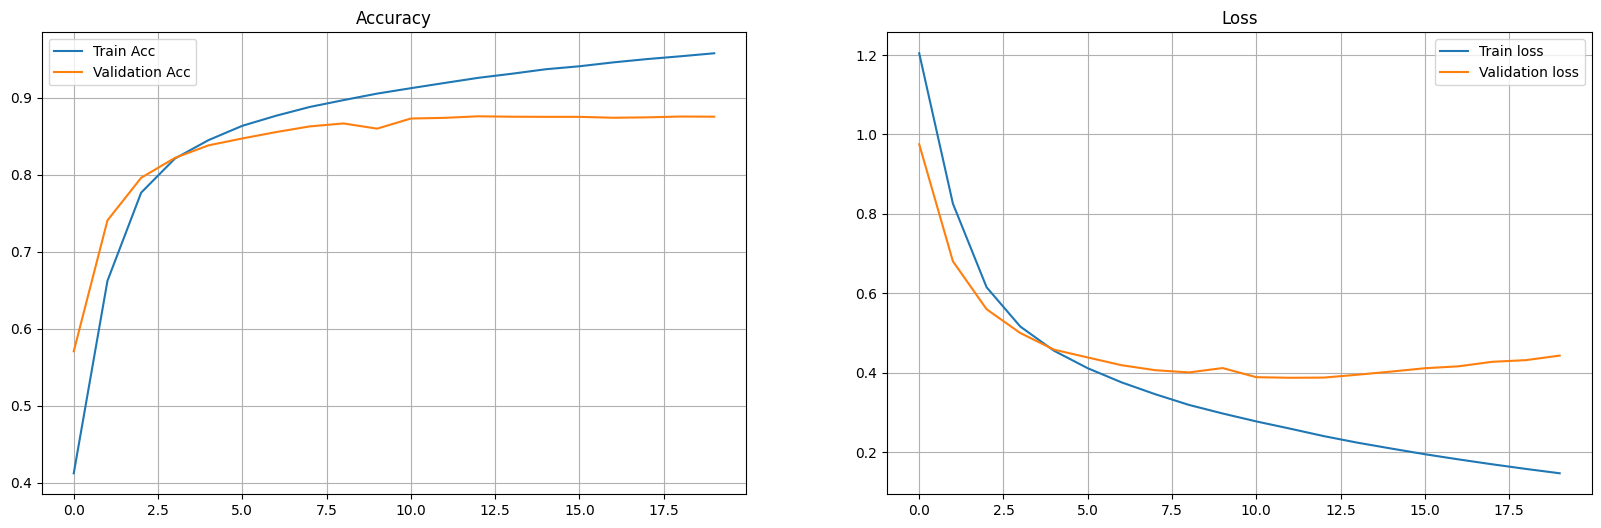

In [9]:
trainer= Trainer(model=model,
                 train_loader=train_loader,
                 val_loader=valid_loader,
                 criterion=criterion,
                 optimizer=optimizer)
trainer.train(EPOCHS)
trainer.print_best_acc()
trainer.plot()